In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pylab as plt
import IPython.display as ipd

import numpy as np
import torch
from utils import *
%matplotlib inline

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import librosa

In [5]:
sample_rate = 22050
wav_path = './sample.wav'

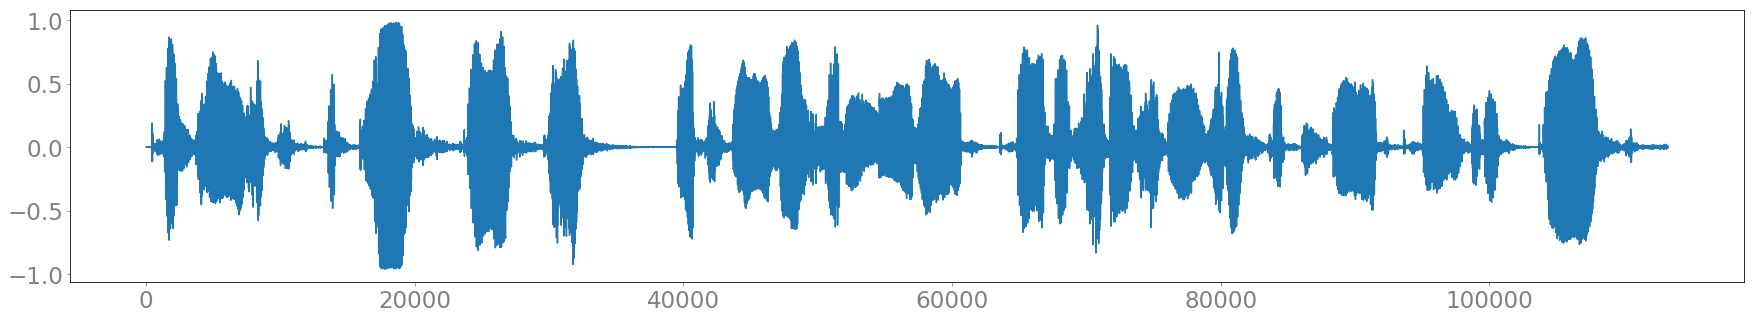

In [6]:
signal = librosa.load(wav_path, sr=sample_rate)[0]
plot(signal)

In [7]:
import audio

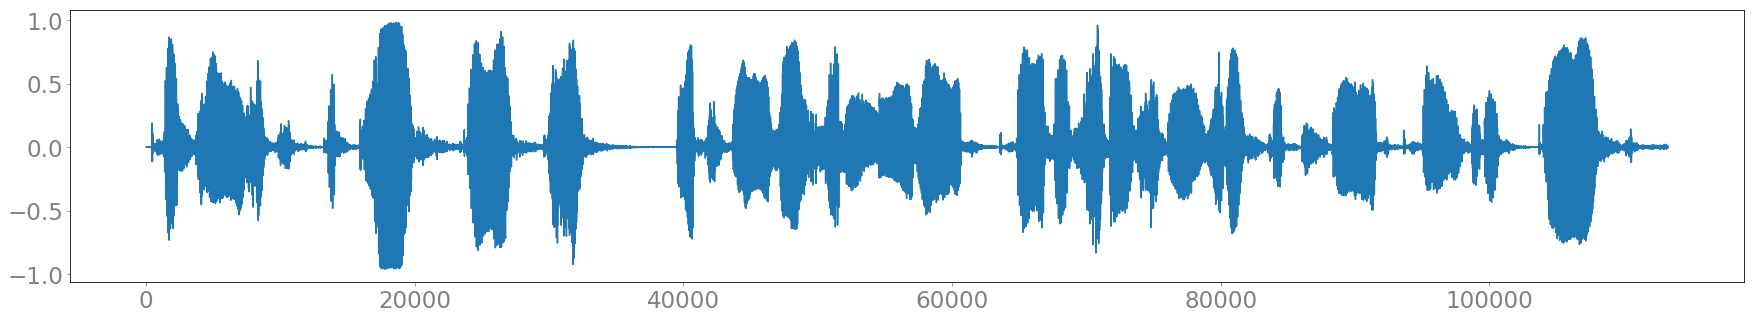

In [8]:
wav = audio.load_wav(wav_path)
plot(wav)

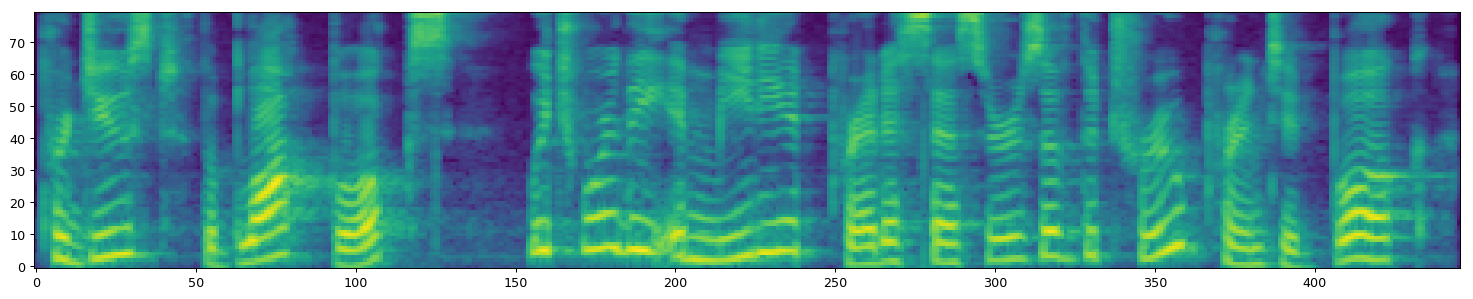

In [9]:
spec = audio.melspectrogram(wav)
def display_spec(data):
    plt.figure(1,figsize=(20,20),dpi=92)
    plt.imshow(data, origin='bottom' )
display_spec(spec)

In [10]:
from hparams import hparams

In [11]:
w_len = wav.shape[0]//256 * 256
wav = wav[:w_len]
spec = audio.melspectrogram(wav)
print(spec.shape, wav.shape)

(80, 445) (113152,)


In [12]:
assert((wav.shape[0])/256 + 3 == 445)

In [13]:
seg_len = 50 * 256
max_val = w_len - seg_len
def gen_data(batch_size=100):
    b = []
    specs = []
    for i in range(batch_size):
        offset = np.random.randint(max_val)
        d = wav[offset: offset + seg_len]
        s = audio.melspectrogram(d)[:,:-3]
        b.append(d)
        specs.append(s)
    return np.array(b), np.array(specs)


In [14]:
x, y = gen_data(10)
print(x.shape)
print(y.shape)

(10, 12800)
(10, 80, 53)


In [38]:
DEFAULT_LAYERS_PARAMS = [
 (2, 16, 128, 0),
 (2, 16, 64, 0),
 (2, 16, 32, 0),
 (2, 16, 16, 0),
 (2, 16, 8, 0),
 (2, 16, 4, 0),
 (2, 16, 2, 0),
 (2, 16, 1, 0)]

In [39]:
class MCNN(nn.Module):
    def __init__(self, n_heads=3, layer_params=DEFAULT_LAYERS_PARAMS):
        super(MCNN, self).__init__()
        self._heads = nn.ModuleList()
        for i in range(n_heads):
            h = self._create_head(layer_params)
            self._heads.append(h)
        self.linear = nn.Linear(n_heads, 1)
        self.act_fn = nn.Softsign()
    
    def forward(self, x):
#         import pdb; pdb.set_trace();
        b = x.shape[0]
        out = [head(x).reshape(-1, 1) for head in self._heads]
        out = torch.cat(out, dim=1)
        out = self.linear(out)
        out = self.act_fn(out).reshape(b, -1)
        return out
        
    def _create_head(self, layer_params):
        layers = []
        for i, p in enumerate(layer_params):
            stride, kernel_size, out_channels, add = p
            if i == 0:
                in_channels = 80
            else:
                in_channels = layer_params[i-1][2]
            padding = (kernel_size - stride)//2
            m = torch.nn.ConvTranspose1d(in_channels, out_channels, kernel_size + add, stride=stride, padding=padding)
            layers.append(m)
            layers.append(nn.ELU())
            
        return nn.Sequential(*layers).cuda()

In [49]:
def get_magnitude(stft_res):
    real = stft_res[:, :, :, 0]
    im = stft_res[:, :, :, 1]
    return torch.sqrt(torch.pow(real, 2) + torch.pow(im, 2))
def compute_stft(x):
    _window = torch.hann_window(1024).cuda()
    stft = torch.stft(x, 1024, win_length=1024, hop_length=64, window=_window, center=False, normalized=True).cuda().transpose(1,2)
    stft /= _window.pow(2).sum().sqrt()
    return get_magnitude(stft)

In [50]:
def compute_loss(y, target):
    b = y.shape[0]
    stft_y = compute_stft(y).reshape(b, -1)
    stft_target = compute_stft(target).reshape(b, -1)
    p1 = torch.norm(stft_target - stft_y, p=2, dim=1)
    p2 = torch.norm(stft_target, p=2, dim=1)
    sc_loss = torch.mean(p1/(p2 + 1e-9))
    return sc_loss
#     log_loss = torch.norm(torch.log(torch.abs(stft_target) + 1e-8) - torch.log(torch.abs(stft_y) + 1e-8), p=1, dim=1)
#     print(log_loss.shape)
#     log_loss = torch.mean(log_loss)
#     loss = sc_loss + 3.0 * log_loss
#     return loss

In [51]:
def train(model, optimizer, lr, steps, batch_size=48) :
    for p in optimizer.param_groups : p['lr'] = lr
    start = time.time()
    running_loss = 0
    
    for i in range(steps) :
        y, x = gen_data(batch_size=batch_size)
        x = torch.tensor(x, requires_grad=False).float().cuda()
        y = torch.tensor(y, requires_grad=False).float().cuda()
        optimizer.zero_grad()
        predict = model(x)
        
        if i % 1000 == 1:
            t1 = y[0].data.cpu().numpy()
            t2 = predict[0].data.cpu().numpy()
            audio.save_wav(t2, 'outs/generate_{}.wav'.format(i))
            audio.save_wav(t1, 'outs/target_{}.wav'.format(i))
            #print('save done!')

        loss = compute_loss(predict, y)        
        loss.backward()
        optimizer.step()
        speed = (i + 1) / (time.time() - start)
        t = time_since(start)
        l = loss
        display('Batches: %i/%i -- Loss: %.4f -- T: %s -- Speed: %.1f steps/sec ', 
                (i + 1, 500000, l, t, speed))

In [ ]:
from torch import optim
model = MCNN(4)
model = model.cuda()
optimizer = optim.Adam(model.parameters())
train(model, optimizer, lr=0.5 * 1e-4, steps=500_000, batch_size=36)

Batches: 377/500000 -- Loss: 1.0004 -- T: 1m 33s -- Speed: 4.1 steps/sec 

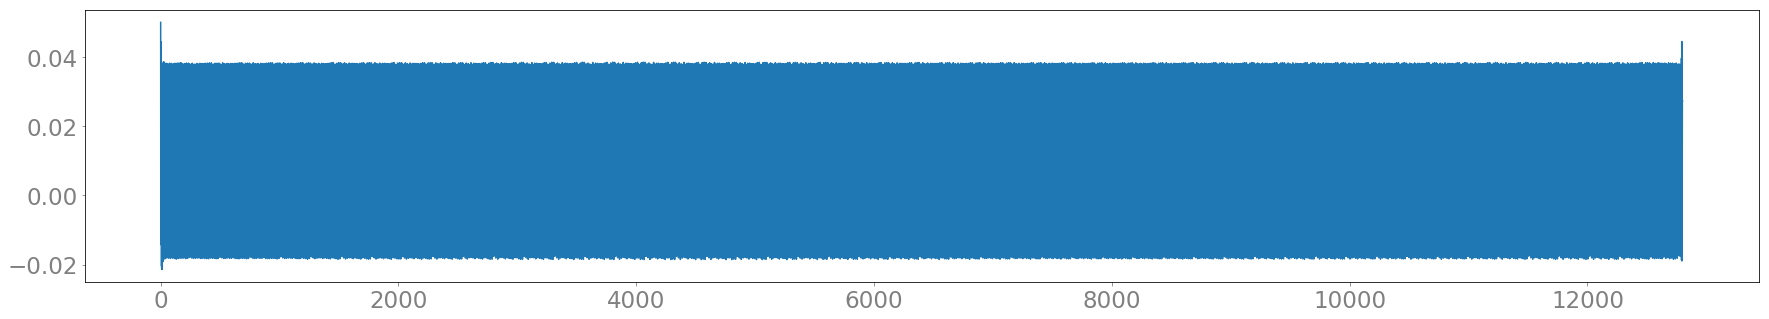

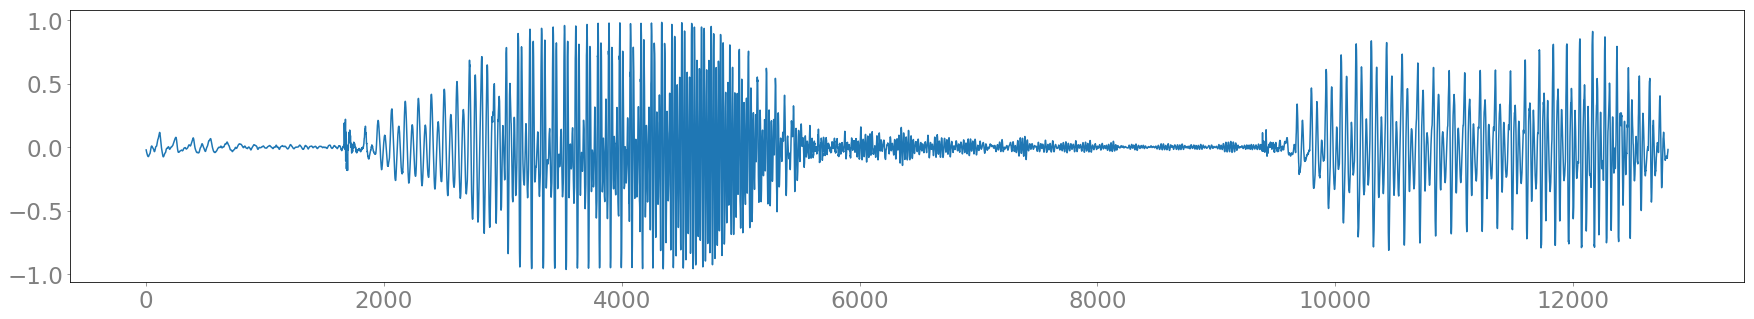

In [46]:
# test
t = model(torch.FloatTensor(spec).cuda())
plot(t[0].data.cpu().numpy())
plot(x[0])